In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
# Let's initialize the square lattice of size (L,L)
def init(L):
        state = np.random.choice([1,-1],size = (L,L)) # the spin along z can have only value [1;-1]
        return state


    
#Let's define the energy of the lattice; in this definition there are periodical boundary conditions. Every configuration has its own energy.
def energy_dimensionless(configuration,L):
    energy_tot = 0
    for i in range(L):
        for j in range(L):
            spin = configuration[i,j]
            n_nb = configuration[i,(j-1)%L] + configuration[i,(j+1)%L] +configuration[(i-1)%L,j] + configuration[(i+1)%L,j]
            energy_tot += -n_nb*spin
    return energy_tot/2
            
    
    
# Let's define the total magnetization of the system
def magnetization(configuration):
    Magn = np.sum(configuration)
    
    return Magn


In [3]:
# Let's define a function for a Metropolis Monte Carlo simulation: Randomically it changes the value of spins if the energy is negative or with a given probability (p = exp(−βΔE) definition of statistical mechanics)
def MC_step(L,configuration,beta):
    for i in range(L):
        for j in range(L):
            a = np.random.randint(L)
            b = np.random.randint(L)
            sigma_random = configuration[a,b]
            neighbours = configuration[a,(b-1)%L] + configuration[a,(b+1)%L] + configuration[(a-1)%L,b] + configuration[(a+1)%L,b]
            delimited_energy = 2*neighbours*sigma_random # why 2?
            probability = np.exp(-beta*delimited_energy)
            if delimited_energy < 0:
                sigma_random *= -1
            elif np.random.rand() < probability:
                sigma_random *= -1
            configuration[a,b] = sigma_random
    return configuration
                

In [7]:
#Let's see a generic configuration of the lattice before and after one Monte Carlo step  at beta = 5,for example:
L= 10
state = init(L)
print(state)
print(energy_dimensionless(state,L))
new_state = MC_step(L,state,5)
print(new_state)
print(energy_dimensionless(new_state,L))

[[-1 -1 -1 -1 -1  1  1  1  1  1]
 [-1 -1  1  1  1  1 -1 -1 -1  1]
 [-1 -1 -1 -1  1 -1  1  1 -1  1]
 [ 1 -1 -1  1  1  1 -1 -1 -1 -1]
 [ 1  1 -1 -1  1 -1 -1  1 -1  1]
 [ 1  1  1  1 -1 -1  1  1  1  1]
 [-1 -1 -1 -1 -1 -1 -1 -1  1 -1]
 [ 1 -1 -1  1 -1 -1 -1  1 -1 -1]
 [ 1  1  1 -1  1 -1 -1 -1  1 -1]
 [-1 -1 -1 -1 -1  1 -1 -1  1  1]]
-12.0
[[ 1 -1 -1 -1 -1  1  1  1  1  1]
 [-1 -1 -1  1 -1  1  1  1  1  1]
 [-1 -1 -1 -1 -1  1 -1 -1  1  1]
 [-1 -1 -1 -1 -1  1 -1 -1 -1 -1]
 [ 1  1  1  1  1  1 -1  1 -1  1]
 [ 1  1  1  1  1  1 -1  1 -1  1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1  1 -1 -1]
 [ 1 -1  1 -1 -1 -1 -1  1 -1  1]
 [ 1 -1 -1 -1 -1  1  1  1  1  1]]
-76.0


In [8]:
# Let's write a function to simulate the dynamic of the system and the calculation of specific heat, magnetization,susceptibility and energy

def dynamic(L,configuration,MCsteps,equilibriumsteps,nt,n_of_simulations):
    #parameters of the dynamic
    nt = nt # number of temperature points(units J/kb) thath we want simulate
    MCsteps = MCsteps
    equilibriumsteps = equilibriumsteps
    
    T_c = 2/math.log(1 + math.sqrt(2)) # critical temperature of 2-D Ising
    
    #initialization of variables(specific heat, magnetization,susceptibility and energy)
    T = np.linspace(1.0,5.0,nt)
    C_theoric,M_theoric =  np.zeros(nt), np.zeros(nt)    
    
    Energies = []
    Magnetizations = []
    SpecificHeats = []
    Susceptibilities = []
    delEnergies = []
    delMagnetizations = []
    delSpecificHeats = []
    delSusceptibilities = []
    
    # simulation core
    
    for t in range(nt):# we will have nt values of the physical variables
        beta = 1.0/T[t]
        for step in range(equilibriumsteps): #termalization phase
            MC_step(L,configuration,beta)
            
        E_n_of_simulations,M_n_of_simulations,C_n_of_simulations,Chi_n_of_simulations = [],[],[],[] 
        
        for i in range(n_of_simulations): # number of repetition for every MonteCarlo complete cycle. After we calculate mean and standard deviation of values
            E, E_squared,M,M_squared = 0,0,0,0 
            for j in range(MCsteps):
                MC_step(L,configuration,beta)
                energy = energy_dimensionless(configuration,L)
                magn = abs(magnetization(configuration))
                
                E += energy
                E_squared += energy**2
                M += magn
                M_squared += magn**2
            # mean of the value on sites(L) and on Monte Carlo time stamps(MCsteps)
            
            E_mean = E/MCsteps
            E_squared_mean = E_squared/MCsteps
            M_mean = M/MCsteps
            M_squared_mean = M_squared/MCsteps
            
            Energy =  E_mean/(L**2)
            Magnetization = M_mean/(L**2)
            SpecificHeat = beta**2 * (E_squared_mean - E_mean**2)/(L**2)
            Susceptibility = beta * (M_squared_mean - M_mean**2)/(L**2)
            
            
            E_n_of_simulations.append(Energy), M_n_of_simulations.append(Magnetization)
            C_n_of_simulations.append(SpecificHeat),Chi_n_of_simulations.append(Susceptibility)
            
        #mean and standard deviation on number of simulations    
        Energy_mean_on_simulations = np.mean(E_n_of_simulations)
        Energies.append(Energy_mean_on_simulations)
        delEnergy_std_on_simulations = np.std(E_n_of_simulations)
        delEnergies.append(float(delEnergy_std_on_simulations))
        
        Magnetization_mean_on_simulations = np.mean(M_n_of_simulations)
        Magnetizations.append(Magnetization_mean_on_simulations)
        delMagnetization_std_on_simulations = np.std(M_n_of_simulations)
        delMagnetizations.append(float(delMagnetization_std_on_simulations))
        
        SpecificHeat_mean_on_simulations = np.mean(C_n_of_simulations)
        SpecificHeats.append(SpecificHeat_mean_on_simulations)
        delSpecificHeat_std_on_simulations = np.std(C_n_of_simulations)
        delSpecificHeats.append(float(delSpecificHeat_std_on_simulations))

        Susceptibility_mean_on_simulations = np.mean(Chi_n_of_simulations)
        Susceptibilities.append(Susceptibility_mean_on_simulations)
        delSusceptibility_std_on_simulations = np.std(Chi_n_of_simulations)
        delSusceptibilities.append(float(delSusceptibility_std_on_simulations))
        
        #theoretical variables value
        
        coeff = math.log(1 + math.sqrt(2))
        if T[t] - T_c >= 0:
            C_theoric[t] = 0
            M_theoric[t] = 0
        else:
            M_theoric[t] = pow(1 - pow(np.sinh(2*beta), -4),1/8) #analytical relation for magnetization given by transfer matrix method 
            C_theoric[t] = (2.0/np.pi) * (coeff**2) * (-math.log(1-T[t]/T_c) + math.log(1.0/coeff) - (1 + np.pi/4))#analytical relation for specific heat
        
    return T,Energies,Magnetizations,SpecificHeats,Susceptibilities, delEnergies, delMagnetizations,delSpecificHeats,delSusceptibilities, C_theoric,M_theoric 
    

In [9]:
# Let's initialize the parameter of the dynamic
L= 10
state_0 = init(L)
MC_steps = 100
equilibrium_steps = 100
nt = 100
n_of_simulations = 10

In [10]:
T,Energies,Magnetizations,SpecificHeats,Susceptibilities, delEnergies, delMagnetizations,delSpecificHeats,delSusceptibilities, C_theoric,M_theoric= dynamic(L,state,100,100,100,10)

In [11]:
T_c = 2/math.log(1 + math.sqrt(2))# critical temperature for Ising 2-D 

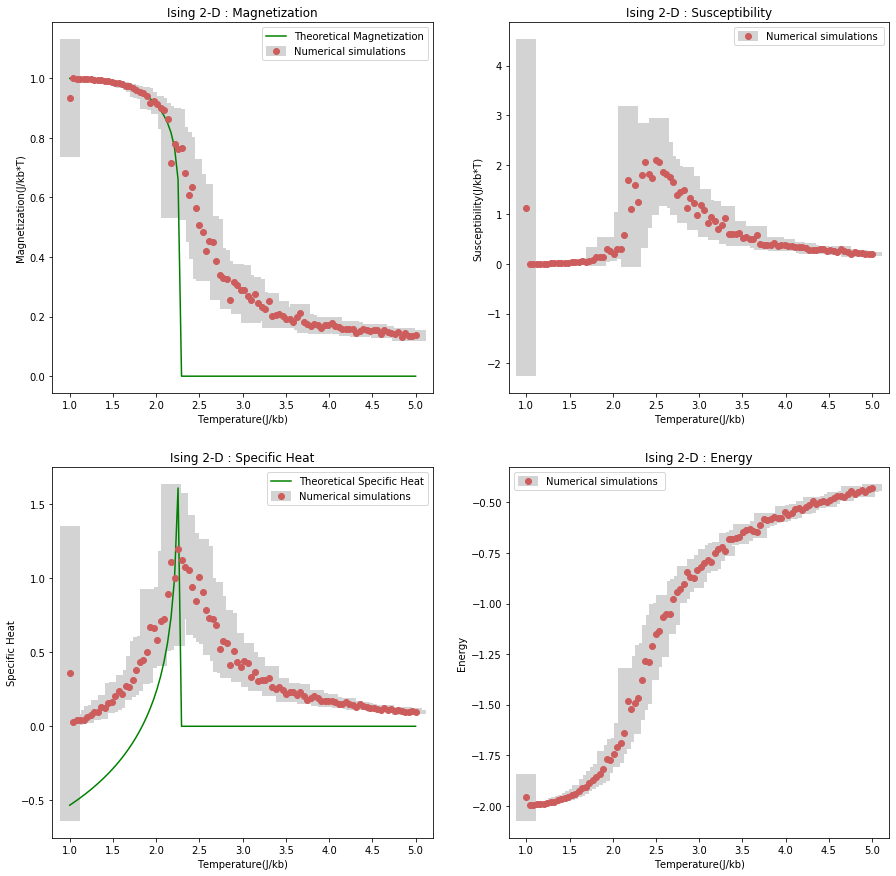

In [12]:
fig,axs = plt.subplots(2,2,figsize = (15,15))

axs[0,0].set_title('Ising 2-D : Magnetization')
axs[0,0].set_xlabel('Temperature(J/kb)')
axs[0,0].set_ylabel('Magnetization(J/kb*T)')
axs[0,0].errorbar(T, Magnetizations, yerr=delMagnetizations, fmt='o', color='IndianRed',ecolor='lightgray', elinewidth=20, capsize=0)
axs[0,0].plot(T, M_theoric, color='Green')
axs[0,0].legend(['Theoretical Magnetization','Numerical simulations '])

axs[0,1].set_title('Ising 2-D : Susceptibility')
axs[0,1].set_xlabel('Temperature(J/kb)')
axs[0,1].set_ylabel('Susceptibility(J/kb*T)')
axs[0,1].errorbar(T, Susceptibilities, yerr=delSusceptibilities, fmt='o', color='IndianRed',ecolor='lightgray', elinewidth=20, capsize=0)
axs[0,1].legend(['Numerical simulations '])


axs[1,0].set_title('Ising 2-D : Specific Heat')
axs[1,0].set_xlabel('Temperature(J/kb)')
axs[1,0].set_ylabel('Specific Heat')
axs[1,0].errorbar(T, SpecificHeats, yerr=delSpecificHeats, fmt='o', color='IndianRed',ecolor='lightgray', elinewidth=20, capsize=0)
axs[1,0].plot(T, C_theoric, color='Green')
axs[1,0].legend(['Theoretical Specific Heat','Numerical simulations '])


axs[1,1].set_title('Ising 2-D : Energy')
axs[1,1].set_xlabel('Temperature(J/kb)')
axs[1,1].set_ylabel('Energy')
axs[1,1].errorbar(T, Energies, yerr=delEnergies, fmt='o', color='IndianRed',ecolor='lightgray', elinewidth=20, capsize=0)
axs[1,1].legend(['Numerical simulations '])


In [13]:
# Chi square test for magnetizations and specific heats values
from scipy.stats import chisquare
Chis_m = chisquare(M_theoric,Magnetizations)
Chis_c = chisquare(C_theoric,SpecificHeats)

print("The chi square test for magnetization is {} while for specific heat is {}".format(Chis_c,Chis_m))

# The numerical results are valid,according to theoretical results.

The chi square test for magnetization is Power_divergenceResult(statistic=82.71032113063671, pvalue=0.8809917197049892) while for specific heat is Power_divergenceResult(statistic=17.141244093194068, pvalue=1.0)
